## Simplified graph with energy consumption, fuel use and emissions
In this notebook, we set up a basic simulation where a vessel moves over a 1D netork path. We add some properties to the graph (depth, width) and the vessel (VesselProperties, ConsumesEnergy) in order to calculate resistance, required power, and emissions.
OpenTNSim model run. 

We take the following steps:

1. [Imports](#1.-Imports)
2. [Create vessel](#2.-Create-vessel)
3. [Create graph](#3.-Create-graph)
4. [Run simulation](#4.-Run-simulation)
5. [Inspect output](#5.-Inspect-output)

### 1. Imports
We start with importing required libraries

In [1]:
# package(s) used for creating and geo-locating the graph
import networkx as nx  
from shapely.geometry import Point,LineString
import pyproj
import warnings

# package(s) related to the simulation (creating the vessel, running the simulation)
import datetime, time
import simpy
import opentnsim
import opentnsim.core as core
import opentnsim.energy as energy_
import opentnsim.graph as graph_
import opentnsim.output as output
import opentnsim.vessel as vessel_
import opentnsim.vessel_traffic_service as VTS

# package(s) needed for data handling and inspecting the output
import numpy as np
import pandas as pd

# package(s) needed for plotting
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots

import logging
#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages

from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 


print('This notebook is executed with OpenTNSim version {}'.format(opentnsim.__version__))

This notebook is executed with OpenTNSim version 1.1.2


### 2. Create vessel
We start with creating a vessel class. We call this class a *Vessel*, and add a number of OpenTNSim mix-ins to this class. Each mix-in requires certain input parameters. 

The following mix-ins are sufficient to create a vessel for our problem: 
* _Identifiable_ - allows to give the vessel a name and a random ID, 
* _Movable_ - allows the vessel to move, with a fixed speed, while logging this activity,
   * Movable in turn relies on the mix-ins: _Locatable_, _Routeable_, and _Log_
* _VesselProperties_ - allows to give the vessel specific properties, 
* _ConsumesEnergy_ - enables calculation of resistance, required power and emissions

In [2]:
# Make your preferred class out of available mix-ins.
TransportResource = type("Vessel",
                         (core.Identifiable,
                          core.Movable,
                          vessel_.VesselProperties,  # needed to add vessel properties
                          energy_.ConsumesEnergy,                                                   
                          vessel_.ExtraMetadata,
                          output.HasOutput,
                         ),
                         {},
                        )  # needed to calculate resistances

In [3]:
# Create a dict with all important settings
# NB: set both "v" and "P_tot_given" to None, as they will be set later
# Note that we set "h_squat" as "True". 
# The squat effect makes a great difference for the actual water depth and resistance calculation in shallow water. 
# Here we need to calculate the water depth reduced by squat since what we give the ship is a route with undisturbed water depth h_0.

data_vessel = {"env": None,
               "name": None,
               "origin": None,
               "destination": None,
               "route": None,
               "geometry": None,
               "v": None,  # m/s
               "type":None,
               "B": 11.4,
               "L": 110,
               "H": None, 
               "T": 3.5,      # <=== here we should enter the value from the T strategy notebook
               "safety_margin": 0.2, # for tanker vessel with sandy bed the safety margin is recommended as 0.2 m
               "h_squat": True, # if consider the ship squatting while moving, set to True, otherwise set to False
               "P_installed": 1750.0,
               "P_tot_given": None, # kW
               "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
               "P_hotel_perc": 0.05,
               "P_hotel": None, # None: calculate P_hotel from percentage
               "x": 2,# number of propellers
               "L_w": 3.0 ,
               "C_B":0.85, 
               "C_year":1990,
              }

### 2. Create graph
Next we create a 1D network (a graph) along which the vessel can move. A graph is made of nodes (blue dots in the plot below) and edges (red arrows between the nodes in the plot below). We use the python package networkx to do this. 

For this example, we construct a network of 4 nodes linked by 3 edges. The edges are made bi-directional to allow for two-way traffic, which means that the graph in the end contains 6 edges.

In [4]:
FG = nx.DiGraph()

coordinates = {'A': Point(0, 0),
               'B': Point(0.8983,0),
               'C': Point(1.7966,0), 
               'D': Point(2.6949,0)}

nodes = []
for name,geometry in coordinates.items():
    nodes.append(graph_.Node(name=name, geometry=geometry))
    
edges = [(nodes[0],nodes[1]),(nodes[1],nodes[2]),(nodes[2],nodes[3])]
depths = [6, 6, 4.5]
edges_info = []
for depth in depths:
    edges_info.append({'GeneralDepth':depth})

graph = graph_.DiGraph(edges=edges,edges_info=edges_info)
FG = graph.graph

In [5]:
nodes = []
coordinates = []
labels = {}

for node in FG.nodes:
    nodes.append(node)
    coordinates.append([nx.get_node_attributes(FG, 'geometry')[node].x, nx.get_node_attributes(FG, 'geometry')[node].y])
    labels[node] = node
    
positions = dict(zip(nodes, coordinates))
positions

{'A': [0.0, 0.0], 'B': [0.8983, 0.0], 'C': [1.7966, 0.0], 'D': [2.6949, 0.0]}

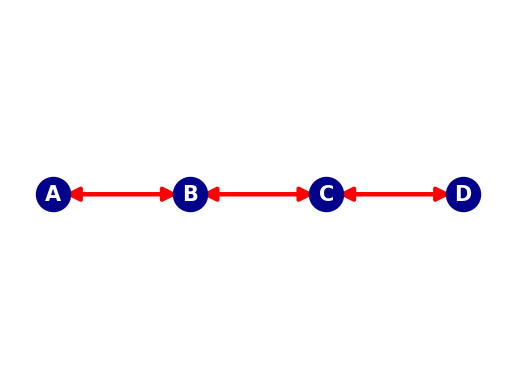

In [6]:
# draw edges, nodes and labels.
nx.draw_networkx_edges(FG, pos=positions, width=3, edge_color="red", alpha=1, arrowsize=20)
nx.draw_networkx_nodes(FG, pos=positions, node_color="darkblue", node_size=600)
nx.draw_networkx_labels(FG, pos=positions, labels=labels, font_size=15, font_weight="bold", font_color="white")

plt.axis("off")
plt.show()

In [7]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))

General depth for edge ('A', 'B') is 6
General depth for edge ('B', 'A') is 6
General depth for edge ('B', 'C') is 6
General depth for edge ('C', 'B') is 6
General depth for edge ('C', 'D') is 4.5
General depth for edge ('D', 'C') is 4.5


### 4. Run simulation
Now we can define the run. After we define the path that the vessel will sail, we make an environment and add the graph to the environment. Then we add one vessel, to which we will append the environment and the route. Lastly, we give the vessel the process of moving from the origin to the destination of the defined path and subsequently run the model.

In [8]:
# create a path along that the vessel needs to follow (in this case from the first node to the last node)
path = nx.dijkstra_path(FG, 'A', 'B')

In [9]:
# Start simpy environment
simulation_start = datetime.datetime.now()
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.simulation_start = simulation_start
env.epoch = time.mktime(simulation_start.timetuple())
env.vessel_traffic_service = VTS.VesselTrafficService()

# Add graph to environment
env.FG = nx.MultiDiGraph(FG)

# Add environment and path to the vessel
# create a fresh instance of vessel
data_vessel['origin'] = 'A'
data_vessel['destination'] = ['B']
vessel = TransportResource(**data_vessel)
vessel.env = env                                        #the created environment
vessel.name = 'Vessel No.1'                     
vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
vessel.metadata['arrival_time'] = simulation_start

# we calculate the energy footprint for a vessel that maintains a speed of 3 m/s (adjusting power accordingly)
vessel.v = 3.0
vessel.P_tot_given = None
          
# Start the simulation
env.process(vessel.move())
env.run()

The energy calculation is performed as a postprocessing step. It requires is input the graph (to acquire information on the water depth) and the vessel log data that was generated during the move activity. The energy use is stored as a dict under _energy_use_ in the energycalculation object.

In [10]:
energycalculation = opentnsim.energy.EnergyCalculation(env.FG, vessel)
energycalculation.calculate_energy_consumption()

AttributeError: 'Vessel' object has no attribute 'logbook'

### 5. Inspect output
We can now analyse the simulation output by inspecting the data in _energy_use_ in the energycalculation object. For convenient inspection it can be loaded into a Pandas dataframe. 

In [ ]:
# create dataframe from energy calculation computation
df = pd.DataFrame.from_dict(energycalculation.energy_use)
df

In [ ]:
df['fuel_kg_per_km'] = (df['total_diesel_consumption_ICE_mass'] / 1000) / (df['distance']/1000)
df['CO2_g_per_km']   = (df['total_emission_CO2']) / (df['distance']/1000)
df['PM10_g_per_km']  = (df['total_emission_PM10']) / (df['distance']/1000)
df['NOx_g_per_km']   = (df['total_emission_NOX']) / (df['distance']/1000)
df